In [11]:
import time
from typing import Optional, Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from myutil import Bias, GA2Mag, PixelNorm2d

In [12]:
torch.__version__

'2.0.1+cu117'

In [13]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='models/mnist',
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root='models/mnist',
    train=False,
    transform=ToTensor(),
    download=True,
)

In [14]:
class TrainHelper:
    @staticmethod
    def train(cnn: nn.Module,
              *,
              epochs: int,
              train_dataset: datasets.MNIST,
              test_dataset: Optional[datasets.MNIST] = None,
              print_results: bool = True,
              batch_size: int,
              device_name: str) -> List[float]:

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=1)

        device = torch.device(device_name)

        cnn.to(device)
        cnn.train()

        optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
        loss_func = nn.CrossEntropyLoss()

        eval_results: List[float] = []

        for epoch in range(epochs):
            for images, labels in train_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))

                output = cnn(images)
                loss = loss_func(output, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if test_dataset is not None:
                eval_result = TrainHelper.test(cnn, test_dataset, device)
                eval_results.append(eval_result)
                if print_results:
                    print(f"epoch {epoch}, accuracy = {eval_result}, loss = {loss.detach()}")
                cnn.train()

        return eval_results

    @staticmethod
    def test(cnn: nn.Module, test_dataset: datasets.MNIST, device=None) -> float:
        cnn.eval()
        loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)
        correct = 0
        incorrect = 0

        for images, labels in loader:
            if device is not None:
                images = images.to(device)

            results = cnn(images)
            predictions = results.detach().cpu().numpy().argmax(axis=1)
            oks = (predictions == labels.numpy()).sum()
            correct += oks
            incorrect += len(predictions) - oks

        return correct / (correct + incorrect)

    @staticmethod
    def train_models(models: List[nn.Module], device_name: str) -> Tuple[int, float]:
        """
        generator yields pair (trainable parameters count, best accuracy) for each network
        :param device_name: 'cuda' or 'cpu'
        """
        assert len(models) > 0

        for model in models:
            start = time.time()
            eval_results = TrainHelper.train(
                cnn=model,
                epochs=20,
                train_dataset=train_data,
                test_dataset=test_data,
                batch_size=2048,
                device_name=device_name,
                print_results=False
            )
            end = time.time()
            best_acc = max(eval_results)
            params_count = TrainHelper.total_parameters_count(model)
            print(f"best accuracy = {best_acc}, parameters = {params_count}, training time = {end - start}")
            yield params_count, best_acc

    @staticmethod
    def total_parameters_count(model: nn.Module) -> int:
        return sum(np.prod(p.size()) for p in model.parameters())

    @staticmethod
    def print_parameters(model: nn.Module):
        print(f"total parameters = {TrainHelper.total_parameters_count(model)}")
        for p in model.parameters():
            print(f"size {np.prod(p.size())}: {p.size()}")

In [15]:
class ComplexConv2d(nn.Module):
    """
    no bias!
    first half of channels is real part, second half - imaginary
    """

    def __init__(self, in_ch_complex: int, out_ch_complex: int, *, kernel_size: int):
        super(ComplexConv2d, self).__init__()
        self.in_ch_complex = in_ch_complex
        self.out_ch_complex = out_ch_complex

        self.conv_re = nn.Conv2d(in_ch_complex, out_ch_complex, bias=False, stride=1, kernel_size=kernel_size,padding='valid')
        self.conv_im = nn.Conv2d(in_ch_complex, out_ch_complex, bias=False, stride=1, kernel_size=kernel_size,padding='valid')

    def forward(self, x):
        assert x.size()[1] == self.in_ch_complex * 2
        re, im = x[:, :self.in_ch_complex], x[:, self.in_ch_complex:]

        out_re = self.conv_re(re) - self.conv_im(im)
        out_im = self.conv_im(re) + self.conv_re(im)

        return torch.cat([out_re, out_im], dim=1)


class GA2Conv2d(nn.Module):
    """
    no bias!
    GA(2, 0, 1), so it has x, y where xx = 1, yy = 1
    """

    def __init__(self, in_ch_ga2: int, out_ch_ga2: int, *, kernel_size: int):
        super(GA2Conv2d, self).__init__()
        self.in_ch = in_ch_ga2
        self.out_ch = out_ch_ga2
        self.convs = nn.ParameterList(
            [nn.Conv2d(self.in_ch, self.out_ch, bias=False, stride=1, kernel_size=kernel_size, padding='valid') for _ in range(4)]
        )

    def forward(self, x):
        assert x.size()[1] == self.in_ch * 4

        ch = self.in_ch
        s, x, y, xy = x[:, :ch], x[:, ch:2 * ch], x[:, 2 * ch:3 * ch], x[:, 3 * ch:4 * ch]

        c_s, c_x, c_y, c_xy = self.convs

        # (a + b x + c y + d xy) (e + f x + g y + h xy) == 
        # (ae + bf + cg + dh) + (af + be - ch + dg)x + (ag + bh + ce - df)y + (ah + bg - cf + de)xy

        # a => c_s, b => c_x, c => c_y, d => c_xy
        # e => s, f => x, g => y, h => xy 

        out_lst = [
            c_s(s) + c_x(x) + c_y(y) + c_xy(xy),
            c_s(x) + c_x(s) - c_y(xy) + c_xy(y),
            c_s(y) + c_x(xy) + c_y(s) - c_xy(x),
            c_s(xy) + c_x(y) - c_y(x) + c_xy(s),
        ]

        return torch.cat(out_lst, dim=1)

In [16]:
class MyConvModel(nn.Module):
    def __init__(self, channels: int, mode: str):
        super(MyConvModel, self).__init__()
        self.channels = channels
        self.mode = mode

        c = channels
        self.conv1 = self.conv(1, c, kernel_size=3)  # 28 - 26
        self.conv2 = self.conv(c, c, kernel_size=3, max_pool=2)  # 26 - 24 - 12
        self.conv3 = self.conv(c, c * 2, kernel_size=3)  # 12 - 10
        self.conv4 = self.conv(c * 2, c * 2, kernel_size=3, max_pool=2)  # 10 - 8 - 4
        self.conv5 = self.conv(c * 2, c * 4, kernel_size=3)  # 4 - 2
        self.conv6 = self.conv(c * 4, c * 4, kernel_size=2)  # 2 - 1
        self.conv7 = self.conv(c * 4, 10, kernel_size=1, use_activation=False, use_bn=False)
        self.to_real: Optional[nn.Module] = GA2Mag()
        self.flatten = nn.Flatten()

    def conv(self, in_ch: int, out_ch: int, *, kernel_size, max_pool: int = 1, use_activation: bool = True, use_bn: bool = True):
        layers: List[nn.Module] = []

        if self.mode == 'complex':
            layers.append(ComplexConv2d(in_ch * 2, out_ch * 2, kernel_size=kernel_size))
        elif self.mode == 'ga2':
            layers.append(GA2Conv2d(in_ch, out_ch, kernel_size=kernel_size))
        elif self.mode == 'naive':
            layers.append(nn.Conv2d(in_ch * 4, out_ch * 4, kernel_size=kernel_size, padding='valid', bias=False))
        else:
            raise NameError(f"wrong mode: {self.mode}")

        layers.append(Bias(out_ch * 4))
        
        if use_bn:
            layers.append(PixelNorm2d())

        if max_pool != 1:
            layers.append(nn.MaxPool2d(kernel_size=max_pool))

        if use_activation:
            layers.append(nn.LeakyReLU(0.1))

        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        x = torch.cat([x, x * 0.0, x * 0.0, x*0.0], dim=1)  # convert to ga2
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        if self.to_real is not None:
            x = self.to_real(x)
        x = self.flatten(x)
        return x

In [17]:
modes = ['naive', 'complex', 'ga2']
channel_multipliers = [4, 6, 8, 12, 16, 24, 32]
results = {mode: [] for mode in modes}

## Cell below could be executed several times to get more points

In [18]:
for i in range(1):
    for mode in modes:
        models = [MyConvModel(n, mode=mode) for n in channel_multipliers]
        for pair in TrainHelper.train_models(models, device_name='cuda'):
            results[mode].append(pair)

best accuracy = 0.9935, parameters = 54344, training time = 92.80442547798157
best accuracy = 0.9942, parameters = 119704, training time = 94.98770380020142
best accuracy = 0.9945, parameters = 210536, training time = 95.79285383224487
best accuracy = 0.9951, parameters = 468616, training time = 95.42299675941467
best accuracy = 0.9946, parameters = 828584, training time = 95.67196226119995
best accuracy = 0.9949, parameters = 1854184, training time = 107.9557089805603
best accuracy = 0.9949, parameters = 3287336, training time = 121.08321022987366
best accuracy = 0.9919, parameters = 27304, training time = 92.19310975074768
best accuracy = 0.9934, parameters = 60040, training time = 93.09030985832214
best accuracy = 0.9938, parameters = 105512, training time = 96.6804449558258
best accuracy = 0.9947, parameters = 234664, training time = 97.13814187049866
best accuracy = 0.9951, parameters = 414760, training time = 120.27715182304382
best accuracy = 0.9953, parameters = 927784, trainin

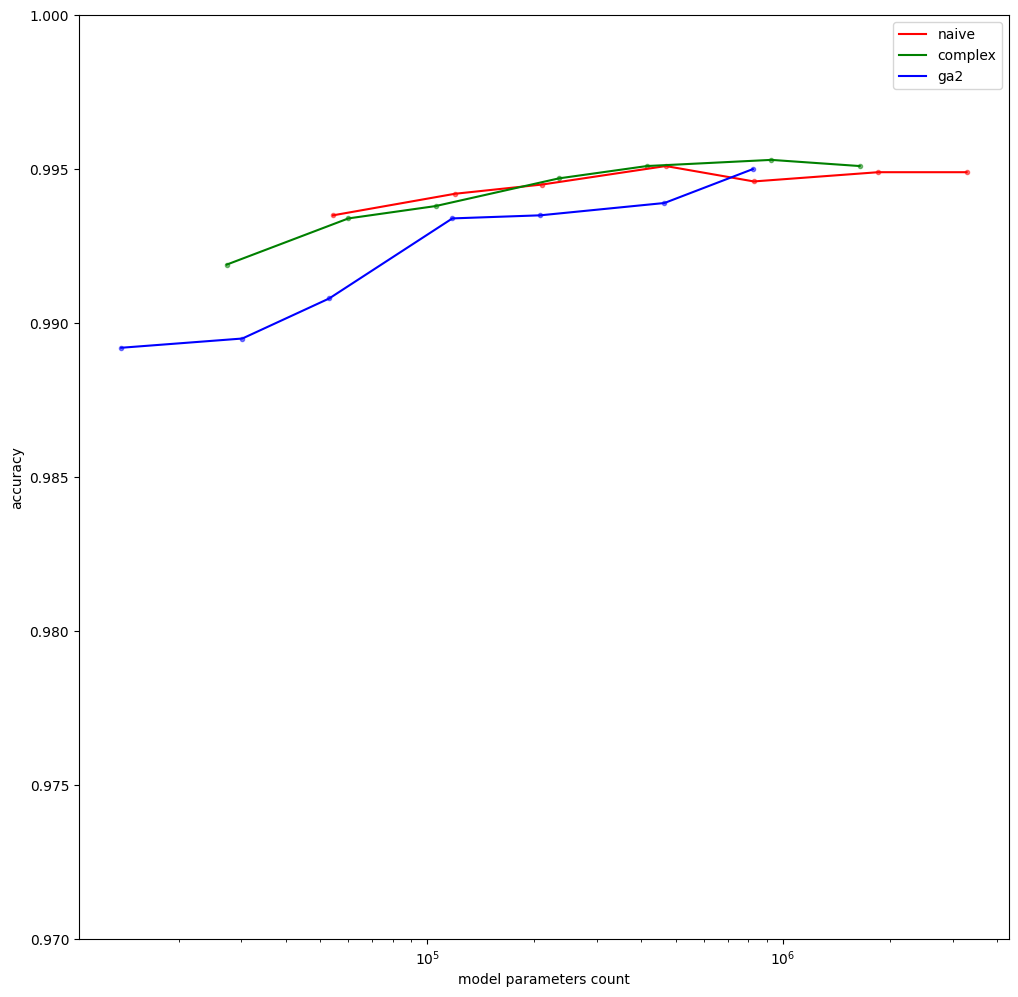

In [19]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.97, 1)

mode_to_color = {
    'naive': 'red',
    'complex': 'green',
    'ga2': 'blue',
}

for mode in modes:
    mid = {}
    for x, y in results[mode]:
        if x not in mid:
            mid[x] = []
        mid[x].append(y)

    mid_pairs = sorted([(x, np.mean(lst)) for x, lst in mid.items()], key=lambda pair: pair[0])
    ax.plot([p[0] for p in mid_pairs], [p[1] for p in mid_pairs], c=mode_to_color[mode], label=mode)

for mode in modes:
    list_of_pairs = results[mode]
    params_counts = [p[0] for p in list_of_pairs]
    accuracies = [p[1] for p in list_of_pairs]

    ax.scatter(params_counts, accuracies, c=mode_to_color[mode], alpha=0.5, marker=r'.')

ax.legend()
plt.xlabel("model parameters count")
plt.ylabel("accuracy")
plt.show()

In [20]:
results

{'naive': [(54344, 0.9935),
  (119704, 0.9942),
  (210536, 0.9945),
  (468616, 0.9951),
  (828584, 0.9946),
  (1854184, 0.9949),
  (3287336, 0.9949)],
 'complex': [(27304, 0.9919),
  (60040, 0.9934),
  (105512, 0.9938),
  (234664, 0.9947),
  (414760, 0.9951),
  (927784, 0.9953),
  (1644584, 0.9951)],
 'ga2': [(13784, 0.9892),
  (30208, 0.9895),
  (53000, 0.9908),
  (117688, 0.9934),
  (207848, 0.9935),
  (464584, 0.9939),
  (823208, 0.995)]}